In [1]:
import pickle as pkl
import numpy as np
import scipy.linalg as linalg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import mne
from sklearn.metrics import (
    balanced_accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
from pyriemann.estimation import Covariances
from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import TSclassifier, MDM, FgMDM, KNearestNeighbor

In [2]:
X = list()
meta = list()
for subj_range in ["1_40", "41_80", "81_109"]:
    with open(f"../data/beetl/phy_vin_{subj_range}.pkl", mode="rb") as f:
        _X, _labels, _meta = pkl.load(f)["data"]
        X.append(_X)
        _meta["label"] = _labels
        meta.append(_meta)

X = np.concatenate(X, axis=0)
meta = pd.concat(meta)

meta = meta[
    (meta["label"].isin(["feet", "hands", "left_hand", "right_hand"]))
    & (~meta["subject"].isin([88, 92, 100, 104]))
]
X = X[meta.index]
meta = meta.reset_index(drop=True)

print(X.shape)
meta

(18896, 28, 385)


,subject,session,run,label
0,1,session_0,run_4,right_hand
1,1,session_0,run_4,left_hand
2,1,session_0,run_4,left_hand
3,1,session_0,run_4,right_hand
4,1,session_0,run_4,right_hand
...,...,...,...,...
18891,109,session_0,run_13,hands
18892,109,session_0,run_13,feet
18893,109,session_0,run_13,hands
18894,109,session_0,run_13,feet


In [3]:
le = LabelEncoder()
meta["label"] = le.fit_transform(meta["label"])

In [4]:
le.classes_

array(['feet', 'hands', 'left_hand', 'right_hand'], dtype=object)

In [11]:
def covariance(x):
    t = x.shape[-1]
    x -= np.mean(x, axis=-1, keepdims=True)
    x = (x @ x.transpose((1, 0))) / (t - 1)

    return x

In [15]:
def safe_log(x):
    return np.log(np.maximum(x, 1e-8))

<AxesSubplot:>

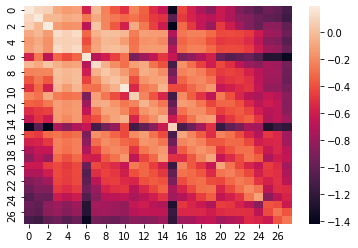

In [16]:
x = X[0]
c = covariance(x)

sb.heatmap(safe_log(c))

In [5]:
subjects = sorted(meta["subject"].unique())

train_subjects = subjects[:-20]
val_subjects = subjects[-20:]

In [6]:
train_meta = meta[meta["subject"].isin(train_subjects)]
Xtrain = X[train_meta.index, :, :384]
Ytrain = np.array(train_meta["label"]).astype(int)

val_meta = meta[meta["subject"].isin(val_subjects)]
Xval = X[val_meta.index, :, :384]
Yval = np.array(val_meta["label"]).astype(int)

print(Xtrain.shape, np.bincount(Ytrain))
print(Xval.shape, np.bincount(Yval))

(15300, 28, 384) [3837 3813 3856 3794]
(3596, 28, 384) [896 893 900 907]


In [12]:
clf = make_pipeline(
    Covariances("scm"),
    FgMDM(metric=dict(mean="logeuclid", distance="riemann"), n_jobs=-1),
    #     KNearestNeighbor(n_neighbors=5, metric=dict(mean="logeuclid", distance="riemann"), n_jobs=-1),
)

In [13]:
%%time
clf.fit(Xtrain, Ytrain)

CPU times: user 32.1 s, sys: 33.3 s, total: 1min 5s
Wall time: 19.5 s


Pipeline(steps=[('covariances', Covariances()),
                ('fgmdm',
                 FgMDM(metric={'distance': 'riemann', 'mean': 'logeuclid'},
                       n_jobs=-1))])

In [14]:
%%time
Ypred = clf.predict(Xval)

print(confusion_matrix(y_true=Yval, y_pred=Ypred))
print()
print(classification_report(y_true=Yval, y_pred=Ypred))

[[360 240 147 149]
 [336 263 139 155]
 [203 135 271 291]
 [203 159 285 260]]

              precision    recall  f1-score   support

           0       0.33      0.40      0.36       896
           1       0.33      0.29      0.31       893
           2       0.32      0.30      0.31       900
           3       0.30      0.29      0.30       907

    accuracy                           0.32      3596
   macro avg       0.32      0.32      0.32      3596
weighted avg       0.32      0.32      0.32      3596

CPU times: user 5.09 s, sys: 5.44 s, total: 10.5 s
Wall time: 3.54 s


In [10]:
_, mdm = clf.steps[1]

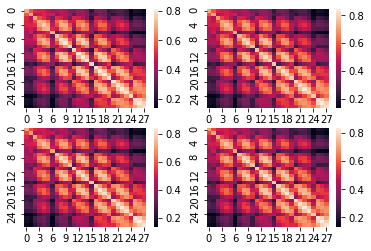

In [11]:
fig, axes = plt.subplots(2, 2)

for i in range(4):
    sb.heatmap(mdm.covmeans_[i], ax=axes[i // 2, i % 2])